In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import datasets
from nilearn.plotting import plot_stat_map
from scipy import stats

from dd_kable_analysis.config_loader import load_config

# What is this?

Please see header of the aggregate results notebook for mvpa_josh_rois for more details.

Generally I'm repeating most of what I did there, but for the Schaefer ROIs.  Since the intial look at the prediction r-squared and Fisher's z indicated the prediction performance was poor and it was likely that often the prediction was close to the mean of the test data, I assumed we'd find the same conclusions here, but ran a subset of the explorations that were run  with the Josh ROIs.

## Summarize how many subjects/voxels for each ROI
All 111 subjects were run for all 200 ROIs, but the voxel counts varied due to dropout.

## Prediction performance
Sadly, it wasn't really any good anywhere.  I ran the check of comparing the sd(y) to the sd(y-hat) and found the variance was much lower for the predicted values.

In [2]:
cfg = load_config()

OUT_ROOT = Path(cfg.output_root) / 'mvpa_schaefer200_amount'


In [3]:
files = sorted(OUT_ROOT.glob('sub-*/roi_summary.csv'))
all_roi = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
# merge (keep only roi_name from the labels table)


# 2) Group mean Fisher-z by roi_label
roi_grp = all_roi.groupby('roi_label', as_index=False).agg(
    roi_label=('roi_label', 'first'),
    n_subs=('sub_id', 'nunique'),
    mean_fisher_z=('fisher_z', 'mean'),
    mean_r=('r', 'mean'),
    mean_r2_cv=('r2_cv', 'mean'),
    mean_rmse=('rmse', 'mean'),
    mean_alpha=('mean_alpha', 'mean'),
)

roi_grp

,roi_label,n_subs,mean_fisher_z,mean_r,mean_r2_cv,mean_rmse,mean_alpha
0,1,111,-0.057029,-0.056532,-0.008768,19.173880,498771.154597
1,2,111,-0.040167,-0.039957,-0.006888,19.155609,487671.533109
2,3,111,-0.040532,-0.040478,-0.011199,19.194658,480353.949042
3,4,111,-0.047906,-0.047623,-0.011786,19.201458,479881.073079
4,5,111,-0.042643,-0.042519,-0.007819,19.164103,462659.044836
...,...,...,...,...,...,...,...
195,196,111,-0.052141,-0.051550,-0.016209,19.244825,458186.544543
196,197,111,-0.050031,-0.049674,-0.011176,19.196169,477304.507693
197,198,111,-0.051362,-0.050906,-0.010130,19.187692,467923.582924
198,199,111,-0.052349,-0.052024,-0.012809,19.212396,460318.168397


# Summarize how many subjects/voxels for each ROI

**All subjects participated for all ROIS**

This is shown in the following histogram

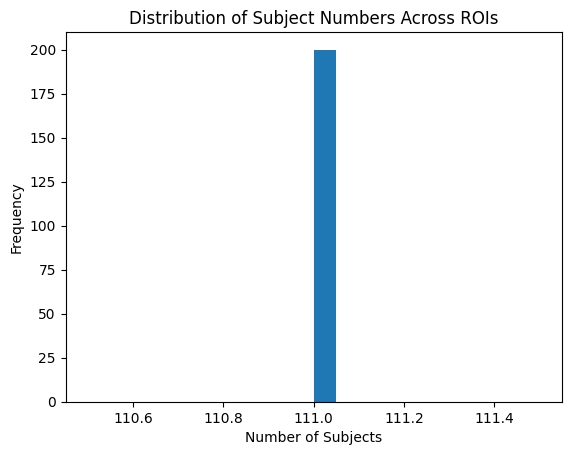

In [4]:
# Distribution of subject numbers across ROIs (all ROIs used all subjects)
plt.hist(roi_grp['n_subs'], bins=20)
plt.xlabel('Number of Subjects')
plt.ylabel('Frequency')
plt.title('Distribution of Subject Numbers Across ROIs')
plt.show()

**ROI size varies generally and retention also varies**

The smallest ROI size for any subject was 319 voxels.  See the below summary figures to get a feel for how the voxel counts varied across ROIs before and after QC.

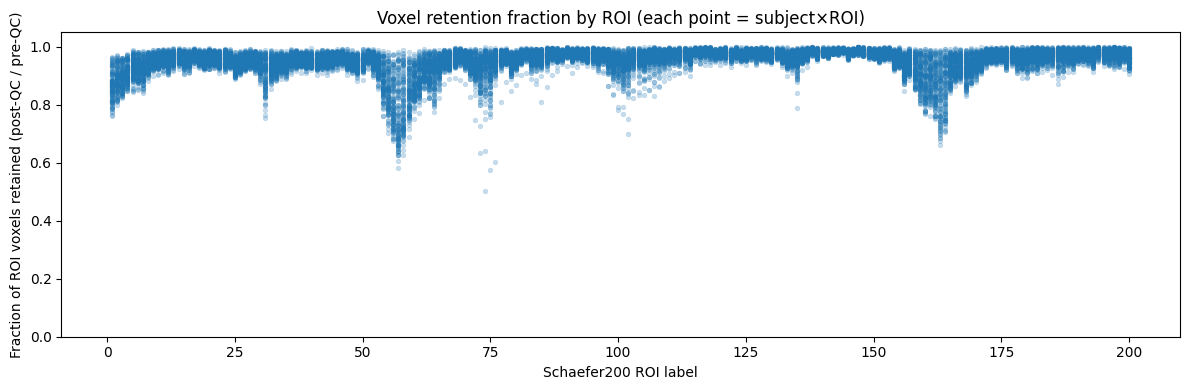

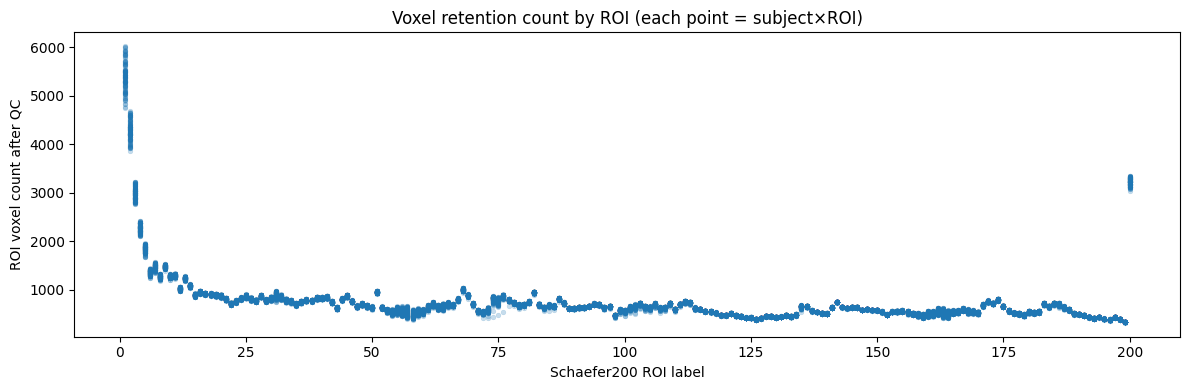

Smallest ROI was 319 voxels across all subjects/ROIs after QC
Distribution of ROI sizes across all ROIs/subjects
count    22200.000000
mean       745.989685
std        537.373332
min        319.000000
25%        538.000000
50%        642.000000
75%        767.000000
max       6025.000000
Name: n_vox_postQC, dtype: float64


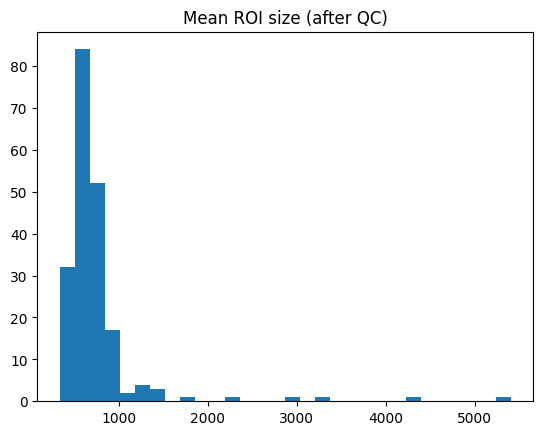

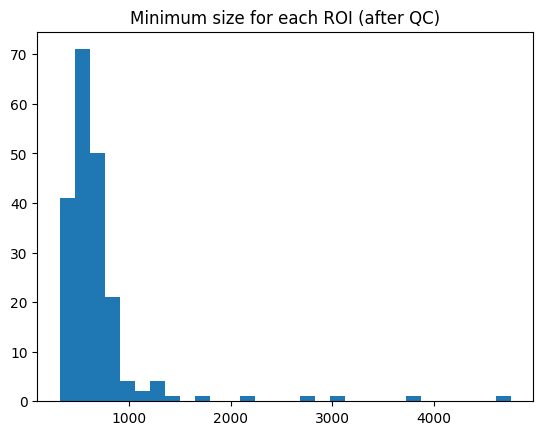

In [5]:
all_roi['frac_roi_retained'] = all_roi['n_vox_postQC'] / all_roi['n_vox_preQC']

plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=all_roi,
    x='roi_label',
    y='frac_roi_retained',
    alpha=0.25,
    s=12,
    edgecolor=None,
)

plt.xlabel('Schaefer200 ROI label')
plt.ylabel('Fraction of ROI voxels retained (post-QC / pre-QC)')
plt.title('Voxel retention fraction by ROI (each point = subject×ROI)')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=all_roi,
    x='roi_label',
    y='n_vox_postQC',
    alpha=0.25,
    s=12,
    edgecolor=None,
)

plt.xlabel('Schaefer200 ROI label')
plt.ylabel('ROI voxel count after QC')
plt.title('Voxel retention count by ROI (each point = subject×ROI)')
plt.tight_layout()
plt.show()

# summary of voxel counts for each ROI

mean_roi_sizes = all_roi.groupby(['roi_label'])['n_vox_postQC'].mean()

min_roi_sizes = all_roi.groupby(['roi_label'])['n_vox_postQC'].min()

print(
    f'Smallest ROI was {all_roi["n_vox_postQC"].min()} voxels across all subjects/ROIs after QC'
)
print('Distribution of ROI sizes across all ROIs/subjects')
print(all_roi['n_vox_postQC'].describe())


plt.hist(mean_roi_sizes, bins=30)
plt.title('Mean ROI size (after QC)')
plt.show()

plt.hist(min_roi_sizes, bins=30)
plt.title('Minimum size for each ROI (after QC)')
plt.show()

# Prediction performance

**mean r-squared and z**

As we found with the Josh ROIs, this is likely a bad sigh that the r-squared values are always negative.  This is likely indicating the predicted values were often the mean amount of the training data.


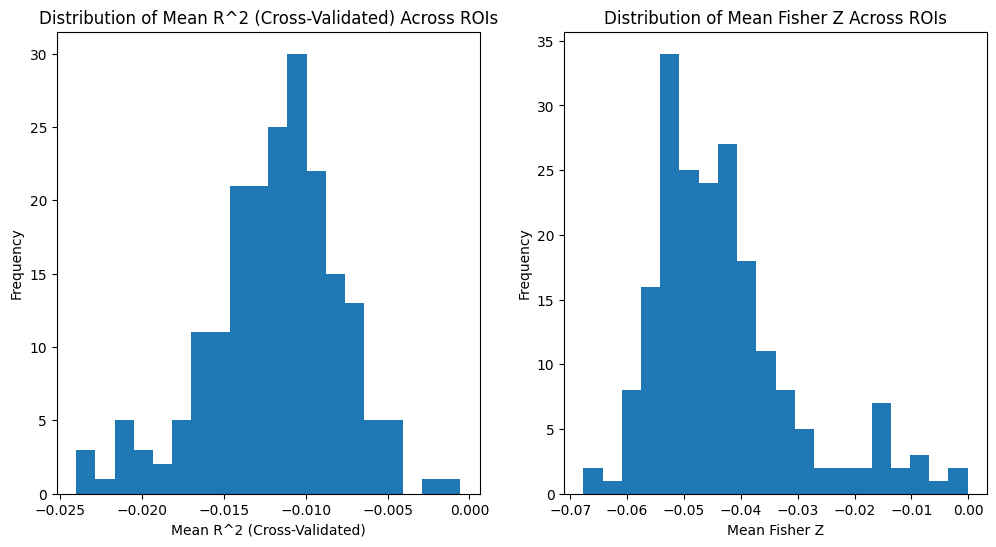

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(roi_grp['mean_r2_cv'], bins=20)
plt.xlabel('Mean R^2 (Cross-Validated)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean R^2 (Cross-Validated) Across ROIs')

plt.subplot(1, 2, 2)
plt.hist(roi_grp['mean_fisher_z'], bins=20)
plt.xlabel('Mean Fisher Z')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Fisher Z Across ROIs')
plt.show()

[fetch_atlas_schaefer_2018] Dataset found in /home/users/jmumford/nilearn_data/schaefer_2018


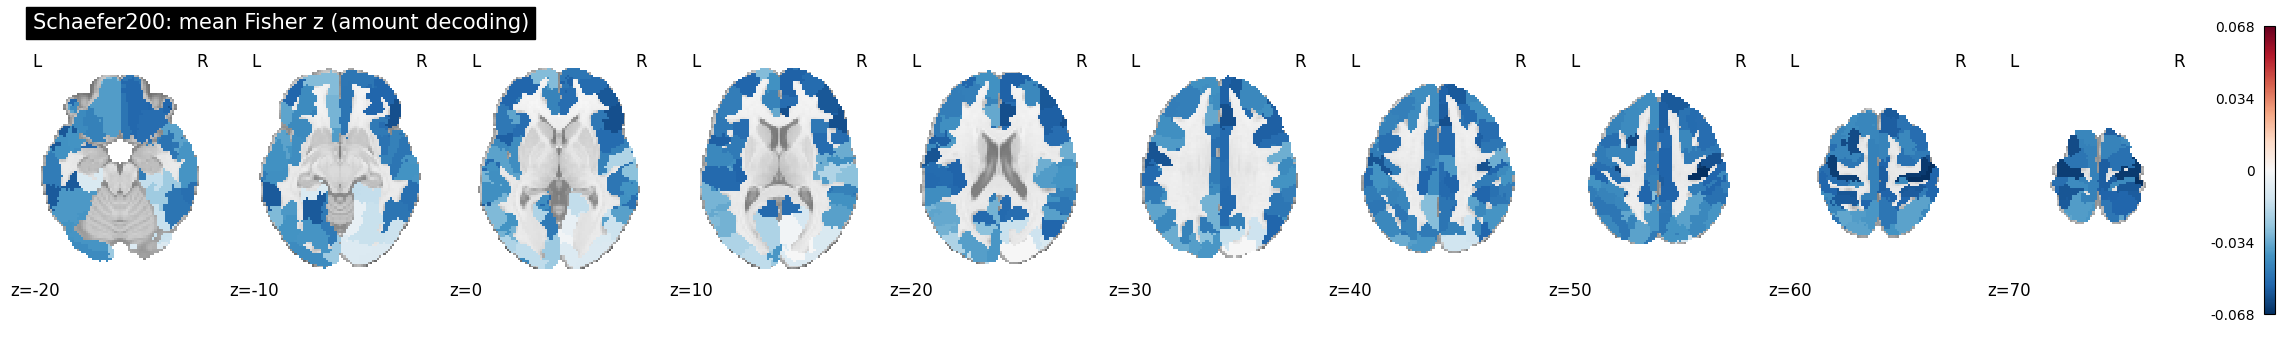

In [7]:
# --- 1) fetch the same Schaefer-200 atlas (2mm) you used for decoding ---
schaefer = datasets.fetch_atlas_schaefer_2018(
    n_rois=200, yeo_networks=7, resolution_mm=2
)
atlas_img = nib.load(schaefer.maps)  # label image, 0=background, 1..200 parcels

atlas_data = atlas_img.get_fdata().astype(int)

# --- 2) build label -> value map from your roi_grp table ---
# assumes roi_grp has columns: roi_label, mean_fisher_z
label_to_val = dict(
    zip(
        roi_grp['roi_label'].astype(int).to_numpy(),
        roi_grp['mean_fisher_z'].astype(float).to_numpy(),
    )
)

# --- 3) paint parcel values into a voxelwise image ---
out_data = np.zeros(atlas_data.shape, dtype=np.float32)
for lab, val in label_to_val.items():
    out_data[atlas_data == lab] = np.float32(val)

stat_img = nib.Nifti1Image(out_data, affine=atlas_img.affine, header=atlas_img.header)

# --- 4) plot ---
plot_stat_map(
    stat_img,
    display_mode='z',
    cut_coords=np.arange(-20, 71, 10),
    title='Schaefer200: mean Fisher z (amount decoding)',
    symmetric_cbar=True,
)
plt.show()

### Look at the prediction values

Here I'll repeat some of the analyses I ran with the Josh ROIs.  In that case I did more to convince myself that the poor prediciton of amount wasn't due to a predictive variability across levels of delay.  Here I will be

* Looking at the ratio of sd(y-hat)/sd(y)
    * This should be close to 1 if prediction is working well
* Look at the correlation between the error and delay
    * If this is very strong, that could indicate a variability in prediction performance is related to delay.  The problem is there could be some other confound driving the effect.  A concern is the predicted values are ofen the mean amount of the training data.
* Estimate the baseline model (prediction is the test data's average amount) and calculate delta error (difference in errors of the orignial prediction and the baseline model)
    * If delta error relates to delay, this indicates that there IS a potentially true variability in predicition accuracy that relates to delay

In [8]:
tw_files = sorted(OUT_ROOT.glob('sub-*/trialwise_preds.csv'))
tw_all = pd.concat([pd.read_csv(f) for f in tw_files], ignore_index=True)

In [9]:
# summary stds
by_sub_roi = tw_all.copy()
by_sub_roi = by_sub_roi.groupby(['sub_id', 'roi_label'], as_index=False).agg(
    y_std=('y', lambda s: float(np.std(s, ddof=1))),
    yhat_std=('yhat_oos', lambda s: float(np.std(s, ddof=1))),
)

by_sub_roi['std_ratio'] = by_sub_roi['yhat_std'] / by_sub_roi['y_std']

by_sub_roi

,sub_id,roi_label,y_std,yhat_std,std_ratio
0,dmp0011,1,19.310235,2.059693,0.106663
1,dmp0011,2,19.310235,2.229138,0.115438
2,dmp0011,3,19.310235,2.450929,0.126924
3,dmp0011,4,19.310235,3.100796,0.160578
4,dmp0011,5,19.310235,3.456920,0.179020
...,...,...,...,...,...
22195,dmp1291,196,19.044170,2.604840,0.136779
22196,dmp1291,197,19.044170,2.383714,0.125168
22197,dmp1291,198,19.044170,2.423837,0.127275
22198,dmp1291,199,19.044170,2.181504,0.114550


**sd ratio is not close to 1 for any ROI**


This indicates poor predictions are occurring.

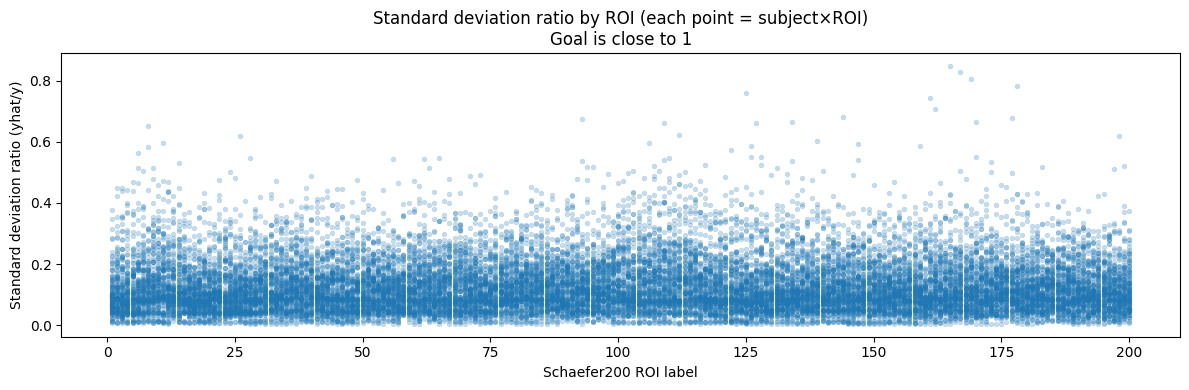

In [10]:
plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=by_sub_roi,
    x='roi_label',
    y='std_ratio',
    alpha=0.25,
    s=12,
    edgecolor=None,
)

plt.xlabel('Schaefer200 ROI label')
plt.ylabel('Standard deviation ratio (yhat/y)')
plt.title(
    'Standard deviation ratio by ROI (each point = subject×ROI)\nGoal is close to 1'
)
plt.tight_layout()
plt.show()

# Is there a relationship between prediction performance and Delay?

It might be the case that the poor prediction is due to there being variability in predictive ability according to delay.  Since the predictions are often close to the mean amount of the training data, to explore this carefully we compare the error from the model we ran to the baseline model to see if they differed.  The baseline model will reflect any uninteresting confound that could be present.

We then compare the delta of the two errors to the delay to see if there's an error improvement that occurs with a change in delay.  This was not found.  Technically it was found in 9 regions, which didn't survive FDR correction.

In [11]:
df = tw_all.copy()

# totals per subject×ROI
tot = (
    df.groupby(['sub_id', 'roi_label'])['amount']
    .agg(sum_amount_all_runs='sum', n_all='size')
    .reset_index()
)

# per-run sums per subject×ROI×run
byrun = (
    df.groupby(['sub_id', 'roi_label', 'run'])['amount']
    .agg(sum_amount_run='sum', n_run='size')
    .reset_index()
)

# compute leave-one-run-out training mean
byrun = byrun.merge(tot, on=['sub_id', 'roi_label'], how='left')
byrun['sum_train'] = byrun['sum_amount_all_runs'] - byrun['sum_amount_run']
byrun['n_train'] = byrun['n_all'] - byrun['n_run']
byrun['yhat_base_oos'] = byrun['sum_train'] / byrun['n_train'].replace(0, np.nan)

# merge baseline prediction back into each trial row
df = df.merge(
    byrun[['sub_id', 'roi_label', 'run', 'yhat_base_oos']],
    on=['sub_id', 'roi_label', 'run'],
    how='left',
    validate='many_to_one',
)

# errors
df['se_model'] = (df['amount'] - df['yhat_oos']) ** 2
df['se_base'] = (df['amount'] - df['yhat_base_oos']) ** 2
df['delta_se'] = df['se_model'] - df['se_base']

# log delay
df['logDelay'] = np.log1p(df['Delay'])

In [12]:
corr_se_model = (
    df.groupby(['sub_id', 'roi_label'], observed=True)[['logDelay', 'se_model']]
    .corr()
    .unstack()
    .iloc[:, 1]  # correlation of logDelay with se_model
    .reset_index(name='corr_logDelay_se_model')
)

corr_se_base = (
    df.groupby(['sub_id', 'roi_label'], observed=True)[['logDelay', 'se_base']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name='corr_logDelay_se_base')
)

corr_delta_se = (
    df.groupby(['sub_id', 'roi_label'], observed=True)[['logDelay', 'delta_se']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name='corr_logDelay_delta_se')
)

corr_all = corr_se_model.merge(
    corr_se_base, on=['sub_id', 'roi_label'], how='inner'
).merge(corr_delta_se, on=['sub_id', 'roi_label'], how='inner')

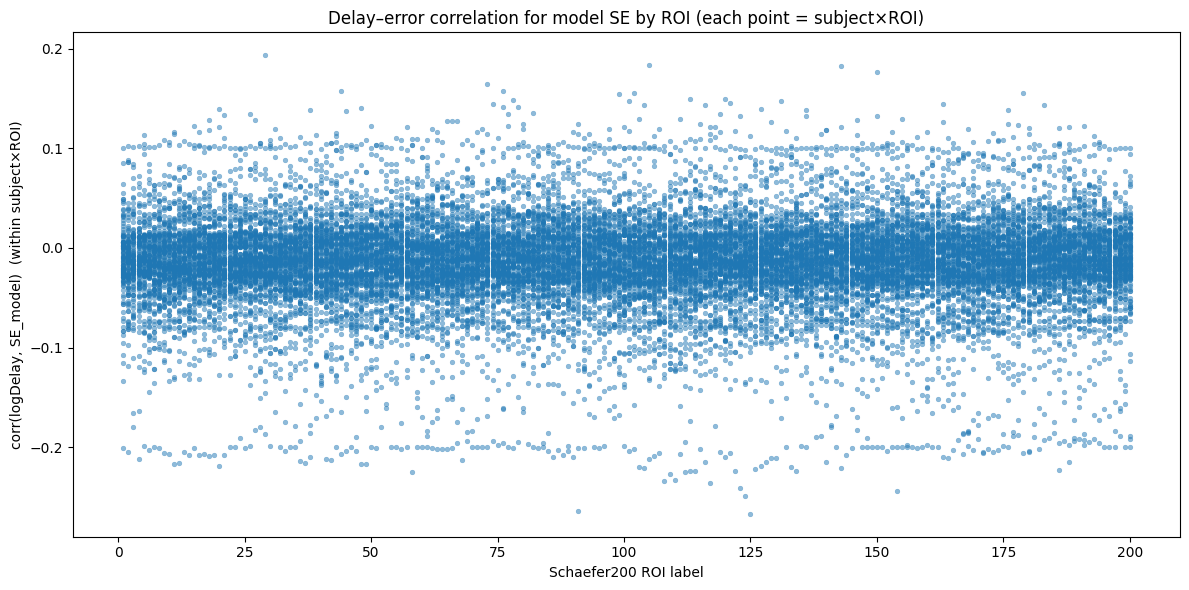

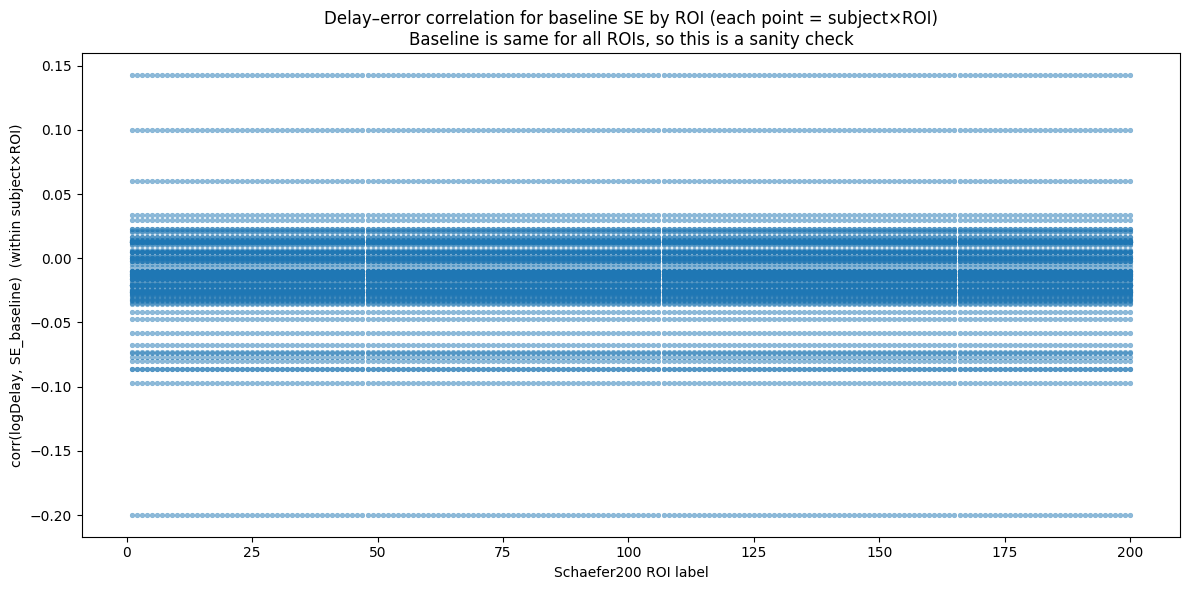

In [13]:
# --- Figure 1: Model SE correlation vs ROI (subject×ROI points) ---
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=corr_all,
    x='roi_label',
    y='corr_logDelay_se_model',
    alpha=0.5,
    s=12,
    edgecolor=None,
)
plt.xlabel('Schaefer200 ROI label')
plt.ylabel('corr(logDelay, SE_model)  (within subject×ROI)')
plt.title('Delay–error correlation for model SE by ROI (each point = subject×ROI)')
plt.tight_layout()
plt.show()


# --- Figure 2: Baseline SE correlation (ROI-invariant) ---
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=corr_all,
    x='roi_label',
    y='corr_logDelay_se_base',
    alpha=0.5,
    s=12,
    edgecolor=None,
)
plt.xlabel('Schaefer200 ROI label')
plt.ylabel('corr(logDelay, SE_baseline)  (within subject×ROI)')
plt.title(
    'Delay–error correlation for baseline SE by ROI (each point = subject×ROI)\nBaseline is same for all ROIs, so this is a sanity check'
)
plt.tight_layout()
plt.show()


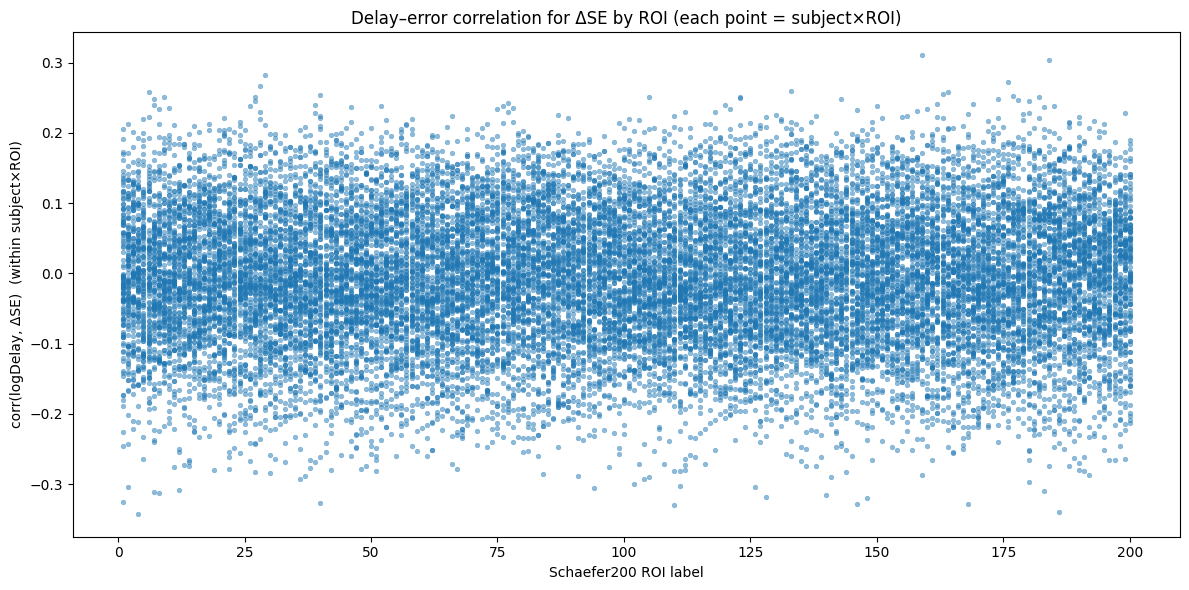

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=corr_all,
    x='roi_label',
    y='corr_logDelay_delta_se',
    alpha=0.5,
    s=12,
    edgecolor=None,
)
plt.xlabel('Schaefer200 ROI label')
plt.ylabel('corr(logDelay, ΔSE)  (within subject×ROI)')
plt.title('Delay–error correlation for ΔSE by ROI (each point = subject×ROI)')
plt.tight_layout()
plt.show()


In [15]:
delta_corr_roi_summary = corr_all.copy()
delta_corr_roi_summary['z'] = np.arctanh(
    np.clip(delta_corr_roi_summary['corr_logDelay_delta_se'], -0.999999, 0.999999)
)

roi_summary = (
    delta_corr_roi_summary.groupby('roi_label')['z']
    .agg(n_subs='size', mean_z='mean', median_z='median', sd_z='std')
    .reset_index()
)
roi_summary['mean_r'] = np.tanh(roi_summary['mean_z'])

We summarize the delay effect at the ROI level by aggregating the subject-specific associations between delay and baseline-relative prediction error. For each subject × ROI, we compute the correlation between logDelay and $\Delta SE$ (where $\Delta SE = SE_{\text{model}} - SE_{\text{baseline}}$; negative values indicate the neural model outperforms the training-mean baseline). To obtain an interpretable group summary per ROI, we Fisher z-transform these correlations ($z=\operatorname{atanh}(r)$), average $z$ across subjects within each ROI, and plot the mean $z$ with a 95% confidence interval; the dashed line at 0 indicates no systematic delay dependence of $\Delta SE$ across subjects.

Total ROIs: 200
Percent of significant ROIs we would expect by chance (5%): 10.0
CIs excluding 0: 9
  above 0: 0
  below 0: 9
CIs including 0: 191


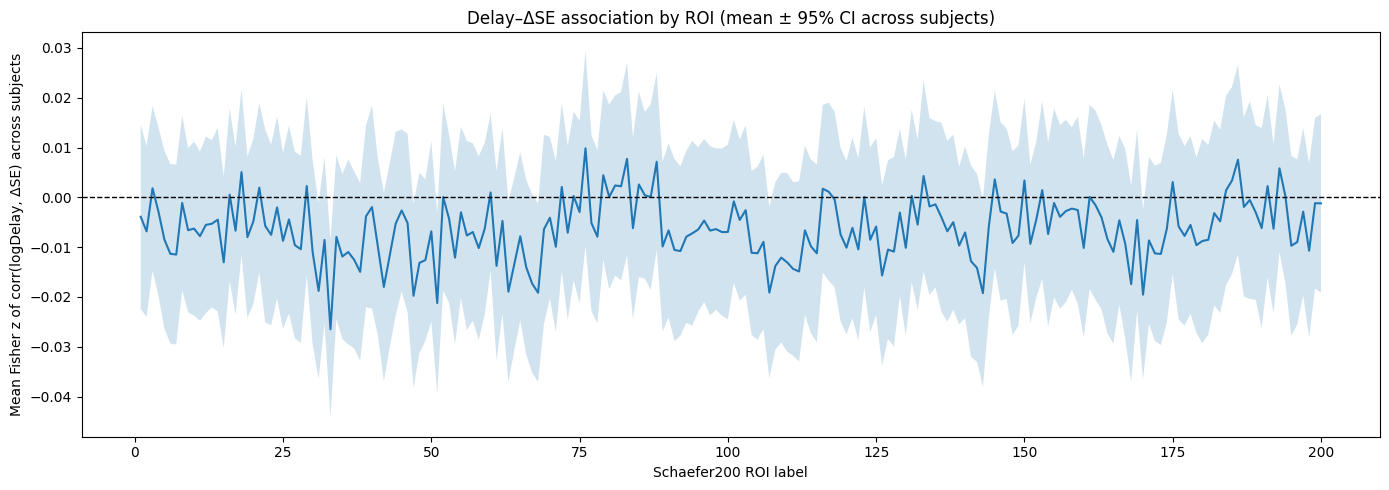

In [16]:
df = corr_all.copy()
r = df['corr_logDelay_delta_se'].astype(float).to_numpy()
df['z'] = np.arctanh(np.clip(r, -0.999999, 0.999999))

roi_sum = (
    df.groupby('roi_label')['z']
    .agg(n='size', mean='mean', sd='std')
    .reset_index()
    .sort_values('roi_label')
)
roi_sum['se'] = roi_sum['sd'] / np.sqrt(roi_sum['n'])
roi_sum['ci_lo'] = roi_sum['mean'] - 1.96 * roi_sum['se']
roi_sum['ci_hi'] = roi_sum['mean'] + 1.96 * roi_sum['se']


# How many CI's don't capture 0?
roi_sum2 = roi_sum.copy()

roi_sum2['ci_excludes_0'] = (roi_sum2['ci_lo'] > 0) | (roi_sum2['ci_hi'] < 0)
roi_sum2['ci_above_0'] = roi_sum2['ci_lo'] > 0
roi_sum2['ci_below_0'] = roi_sum2['ci_hi'] < 0

n_total = len(roi_sum2)
n_excl = int(roi_sum2['ci_excludes_0'].sum())
n_above = int(roi_sum2['ci_above_0'].sum())
n_below = int(roi_sum2['ci_below_0'].sum())
n_includes = n_total - n_excl

print(f'Total ROIs: {n_total}')
print(
    f'Percent of significant ROIs we would expect by chance (5%): {n_total * 0.05:.1f}'
)
print(f'CIs excluding 0: {n_excl}')
print(f'  above 0: {n_above}')
print(f'  below 0: {n_below}')
print(f'CIs including 0: {n_includes}')


plt.figure(figsize=(14, 5))
plt.plot(roi_sum['roi_label'], roi_sum['mean'], lw=1.5)
plt.fill_between(roi_sum['roi_label'], roi_sum['ci_lo'], roi_sum['ci_hi'], alpha=0.2)
plt.axhline(0, color='k', lw=1, ls='--')
plt.xlabel('Schaefer200 ROI label')
plt.ylabel('Mean Fisher z of corr(logDelay, ΔSE) across subjects')
plt.title('Delay–ΔSE association by ROI (mean ± 95% CI across subjects)')
plt.tight_layout()
plt.show()


**This is just exploratory/descriptive**

The 9 significant results are what we'd expect by chance.  Here I'll calculate p-values and FDR correct and display on brains.

ROIs tested: 200
ROIs significant after FDR q<.05: 0
[fetch_atlas_schaefer_2018] Dataset found in /home/users/jmumford/nilearn_data/schaefer_2018


/tmp/ipykernel_29343/3887303502.py:91: UserWarning: empty mask
  plot_stat_map(


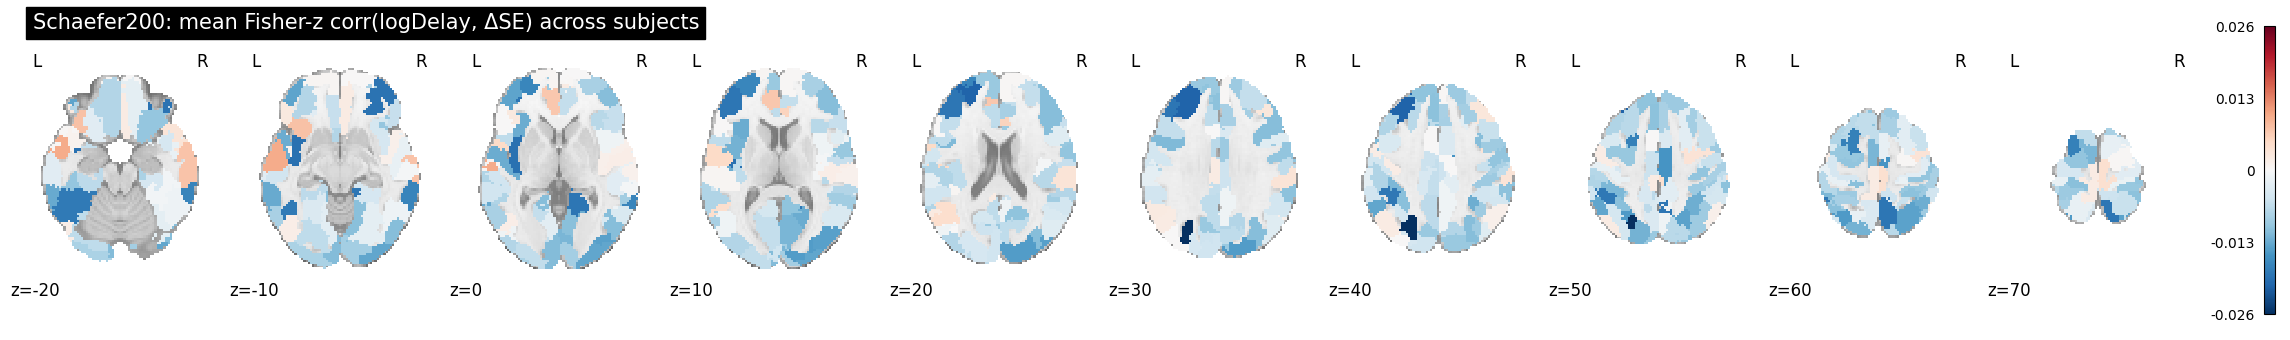

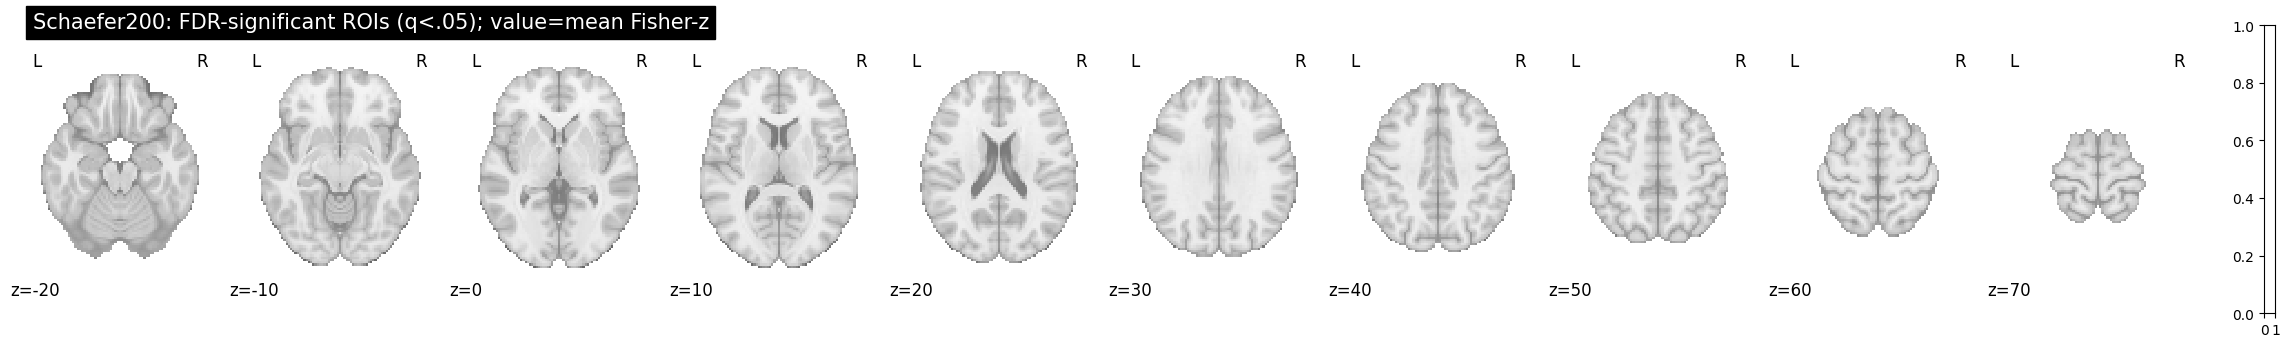

In [17]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets
from nilearn.plotting import plot_stat_map
from statsmodels.stats.multitest import multipletests

# ------------------------------------------------------------
# 1) ROI-wise one-sample tests on subject-level Fisher-z values
#    (testing mean corr(logDelay, ΔSE) != 0 across subjects)
# ------------------------------------------------------------
df = corr_all.copy()
r = df['corr_logDelay_delta_se'].astype(float).to_numpy()
df['z'] = np.arctanh(np.clip(r, -0.999999, 0.999999))

roi_rows = []
for roi, g in df.groupby('roi_label'):
    zvals = g['z'].dropna().to_numpy()
    n = len(zvals)
    if n < 20:  # safety; adjust if needed
        continue
    t, p = stats.ttest_1samp(zvals, 0.0)
    roi_rows.append(
        dict(
            roi_label=int(roi),
            n_subs=int(n),
            mean_z=float(np.mean(zvals)),
            mean_r=float(
                np.tanh(np.mean(zvals))
            ),  # back-transform for interpretability
            t=float(t),
            p=float(p),
        )
    )

roi_stats = pd.DataFrame(roi_rows).sort_values('roi_label').reset_index(drop=True)

# FDR across ROIs
rej, q, _, _ = multipletests(roi_stats['p'].to_numpy(), alpha=0.05, method='fdr_bh')
roi_stats['q_fdr'] = q
roi_stats['sig_fdr_0p05'] = rej

print('ROIs tested:', len(roi_stats))
print('ROIs significant after FDR q<.05:', int(roi_stats['sig_fdr_0p05'].sum()))

# ------------------------------------------------------------
# 2) Fetch Schaefer-200 atlas (2mm) and paint values into images
# ------------------------------------------------------------
schaefer = datasets.fetch_atlas_schaefer_2018(
    n_rois=200, yeo_networks=7, resolution_mm=2
)
atlas_img = nib.load(schaefer.maps)
atlas_data = atlas_img.get_fdata().astype(int)

# Map ROI label -> mean effect (choose z-space or r-space)
label_to_meanz = dict(zip(roi_stats['roi_label'], roi_stats['mean_z']))
label_to_meanr = dict(zip(roi_stats['roi_label'], roi_stats['mean_r']))

# Image 1: continuous effect size map (mean correlation; here in z-space)
img_all = np.zeros(atlas_data.shape, dtype=np.float32)
for lab, val in label_to_meanz.items():
    img_all[atlas_data == int(lab)] = np.float32(val)
meanZ_img = nib.Nifti1Image(img_all, atlas_img.affine, atlas_img.header)

# Image 2: thresholded map (only FDR-significant ROIs; others = 0)
sig_labels = set(
    roi_stats.loc[roi_stats['sig_fdr_0p05'], 'roi_label'].astype(int).tolist()
)
img_sig = np.zeros(atlas_data.shape, dtype=np.float32)
for lab in sig_labels:
    img_sig[atlas_data == int(lab)] = np.float32(label_to_meanz[lab])
sigZ_img = nib.Nifti1Image(img_sig, atlas_img.affine, atlas_img.header)

# Optional: save to disk
# nib.save(meanZ_img, "schaefer200_meanZ_corr_logDelay_deltaSE.nii.gz")
# nib.save(sigZ_img,  "schaefer200_sigFDR_meanZ_corr_logDelay_deltaSE.nii.gz")
# roi_stats.to_csv("roi_fdr_tests_corr_logDelay_deltaSE.csv", index=False)

# ------------------------------------------------------------
# 3) Plot (customize cut coords as requested)
# ------------------------------------------------------------
cut_coords = np.arange(-20, 71, 10)

plot_stat_map(
    meanZ_img,
    display_mode='z',
    cut_coords=cut_coords,
    title='Schaefer200: mean Fisher-z corr(logDelay, ΔSE) across subjects',
)

plot_stat_map(
    sigZ_img,
    display_mode='z',
    cut_coords=cut_coords,
    title='Schaefer200: FDR-significant ROIs (q<.05); value=mean Fisher-z',
)